# ABS Quarterly Financial Accounts 5232

## Python set-up

In [1]:
# system imports
import pathlib
import calendar
import re

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from finalise_plot import finalise_plot, set_chart_dir
from abs_common import (
    get_fs_constants,
    get_plot_constants,
    get_ABS_meta_and_data,
    get_identifier,
    plot_Qgrowth,
    recalibrate_series,
    clear_chart_dir,
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '5232'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

## Get data from ABS

In [3]:
# do the data capture and extraction
abs_dict = get_ABS_meta_and_data(catalogue_id)
if abs_dict is None:
    sys.exit(-1)

Found URL for a ZIP file on ABS web page
Cache looks stale: Removing old cache version
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...


## Plot

### Set-up some constants we will use across all plots

In [4]:
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)

clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)

### Household balance sheet

In [5]:
table = '35'
data = abs_dict[table]
series_type = 'Original'
plots = meta[
    meta['Table'] == table
]['Data Item Description']

for plot in plots:
    ident, orig_units = get_identifier(meta, plot, series_type, table)

    # manage long wordy chart titles
    MAX_LEN = 50
    title = f'HBS: {plot[:-2]}'
    footnote = ''
    replaceable = {
        '- Non-financial -': ['- NF -', ' NF = Non-financial.'],
        '- Fixed assets -': ['- FA -', ' FA = Fixed assets.'],
        '- Financial assets -': ['- FA -', ' FA = Financial assets.']
    }
    for foundling, [replacement, fnote] in replaceable.items():
        if foundling in title and len(title) > MAX_LEN:
            title = title.replace(foundling, replacement)
            footnote = f'{footnote}{fnote}'
    if len(title) > MAX_LEN:
        splits = title.split(' - ')
        title = ' - '.join(splits[:-1]) + ' -\n' + splits[-1]
    
    # plot 
    for start, tag in zip(plot_times, plot_tags):
        frame = data[data.index >= pd.Period(start, freq=data.index.freq)] if start else data
        series = frame[ident]
        series, units = recalibrate_series(series, orig_units)
        
        ax = series.plot(lw=2, color='#dd0000')
        finalise_plot(ax, 
                      title=title, 
                      ylabel=f'{units} current prices', 
                      tag=tag,
                      rfooter=f'{source} {table}',
                      lfooter=f'{series_type.capitalize()} series.'
                               f' HBS = Household balance sheet.{footnote}',
                      #show=True,
                     )

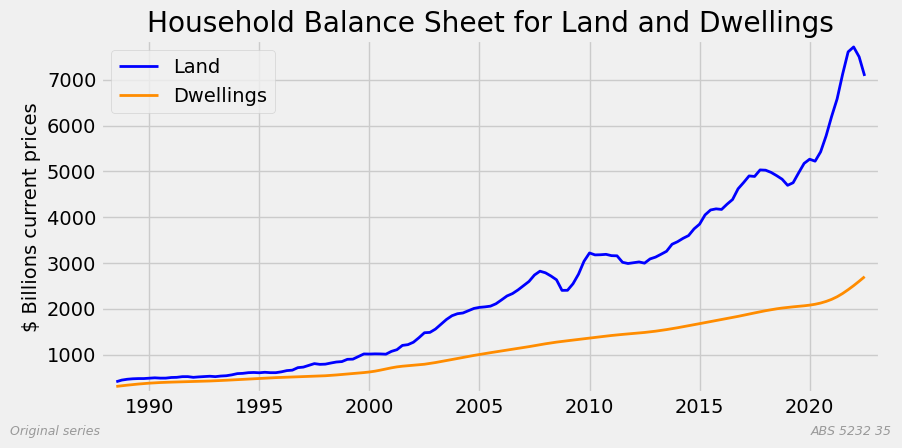

In [6]:
# Land and dwelling assets - side by side
table = '35'
data = abs_dict[table]
series_type = 'Original'
land = 'Non-financial - Non-produced assets - Land ;'
dwellings = 'Non-financial - Produced - Fixed assets - Dwellings ;'
combined = {}
for name, series in zip(('Land', 'Dwellings'), (land, dwellings)):
    ident, units = get_identifier(meta, series, series_type, table)
    combined[name] = data[ident]
combined = pd.DataFrame(combined)
ax = combined.plot(lw=2, color=('blue', 'darkorange'))
title = 'Household Balance Sheet for Land and Dwellings'
finalise_plot(ax, title=title, 
              ylabel=f'{units} current prices', 
              rfooter=f'{source} {table}',
              lfooter=f'{series_type.capitalize()} series',
             show=True)

## Finished

In [7]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sat Feb 18 2023 09:17:57

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.10.0

re        : 2.2.1
matplotlib: 3.7.0
pandas    : 1.5.3
numpy     : 1.24.2

Watermark: 2.3.1



In [8]:
print('Finished')

Finished
